# RNN  for Time Series

Data
Release: Advance Monthly Sales for Retail and Food Services
Units: Millions of Dollars, Not Seasonally Adjusted

Frequency: Monthly

The value for the most recent month is an advance estimate that is based on data from a subsample of firms from the larger Monthly Retail Trade Survey. The advance estimate will be superseded in following months by revised estimates derived from the larger Monthly Retail Trade Survey. The associated series from the Monthly Retail Trade Survey is available at https://fred.stlouisfed.org/series/MRTSSM448USN

Information about the Advance Monthly Retail Sales Survey can be found on the Census website at https://www.census.gov/retail/marts/about_the_surveys.html

Suggested Citation: U.S. Census Bureau, Advance Retail Sales: Clothing and Clothing Accessory Stores [RSCCASN], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/RSCCASN, November 16, 2019.

https://fred.stlouisfed.org/series/RSCCASN

In [37]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing

In [38]:
df = pd.read_csv("RSCCASN.csv", parse_dates=True, index_col='DATE')

In [39]:
df.columns = ['Sales']

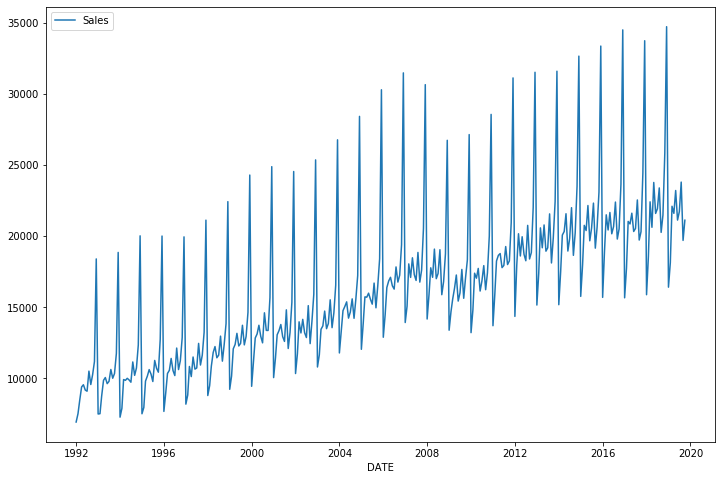

In [40]:
plt.figure(figsize=(12,8))
sns.lineplot(data=df)

 We can see seasonality, some month are more likly to sell liquids every year

## Train Test Split

In [41]:
len(df)

334

In [42]:
12*(2019-1992)

324

In [43]:
test_size = 18 # Months
test_ind = len(df) - test_size

## Saperate to test and train data

In [44]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [45]:
train.tail(2)

,Sales
DATE,
2018-03-01,22404
2018-04-01,20616


In [46]:
test.head(2)

,Sales
DATE,
2018-05-01,23764
2018-06-01,21589


## Scaling the Data

In [30]:
from sklearn.preprocessing import MinMaxScaler

In [31]:
scaler = MinMaxScaler()

In [33]:
scaled_train = scaler.fit_transform(train)

In [36]:
scaled_test = scaler.transform(test)

In [35]:
scaled_test

array([[0.61087714],
       [0.53191258],
       [0.54389341],
       [0.59697212],
       [0.4836625 ],
       [0.52770113],
       [0.68592071],
       [1.00813244],
       [0.34388615],
       [0.40647691],
       [0.55021057],
       [0.53220302],
       [0.59040081],
       [0.51499419],
       [0.53645077],
       [0.61185739],
       [0.46314987],
       [0.51463114]])

## Time series Generator

In [48]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [49]:
length = 12 # whole year and less the the length of the test data
generator_train = TimeseriesGenerator(scaled_train,scaled_train,
                                     length=length, batch_size=1)

In [50]:
X,y = generator_train[0]

In [51]:
X

array([[[0.        ],
        [0.02127505],
        [0.05580163],
        [0.08942056],
        [0.09512053],
        [0.08146965],
        [0.07860151],
        [0.12979233],
        [0.09566512],
        [0.1203892 ],
        [0.15426227],
        [0.41595266]]])

In [52]:
y

array([[0.02047633]])

In [54]:
scaled_train[12]

array([0.02047633])

## Create the Model

In [55]:
from tensorflow.keras.layers import LSTM,Dense

In [56]:
from tensorflow.keras.models import Sequential

In [57]:
n_features = 1

In [58]:
model = Sequential()

model.add(LSTM(12, input_shape=(length,n_features) ))
model.add( Dense(1))
model.compile(optimizer='adam',loss='mse')

In [63]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 12)                672       
_________________________________________________________________
dense (Dense)                (None, 1)                 13        
Total params: 685
Trainable params: 685
Non-trainable params: 0
_________________________________________________________________


### EarlyStopping and creating a Validation Generator

The scaled_test dataset size MUST be greater than length chosen for batches.

In [64]:
from tensorflow.keras.callbacks import EarlyStopping

In [72]:
early_stop = EarlyStopping(monitor='val_loss', patience=5)

In [73]:
validation_generatior = TimeseriesGenerator(scaled_test,scaled_test,
                                           length=length,batch_size=1)

In [74]:
model.fit_generator(generator_train, epochs=20, 
                   validation_data=validation_generatior,
                   callbacks=[early_stop])

Epoch 1/20
 44/304 [===>..........................] - ETA: 0s - loss: 0.0108

C:\Users\Roni\AppData\Roaming\Python\Python37\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


304/304 [==============================] - 1s 4ms/step - loss: 0.0161 - val_loss: 0.0025
Epoch 2/20
304/304 [==============================] - 1s 4ms/step - loss: 0.0161 - val_loss: 0.0101
Epoch 3/20
304/304 [==============================] - 1s 4ms/step - loss: 0.0153 - val_loss: 0.0032
Epoch 4/20
304/304 [==============================] - 1s 4ms/step - loss: 0.0148 - val_loss: 0.0043
Epoch 5/20
304/304 [==============================] - 1s 4ms/step - loss: 0.0137 - val_loss: 0.0032
Epoch 6/20
304/304 [==============================] - 1s 4ms/step - loss: 0.0127 - val_loss: 0.0038


In [75]:
losses = pd.DataFrame(model.history.history)

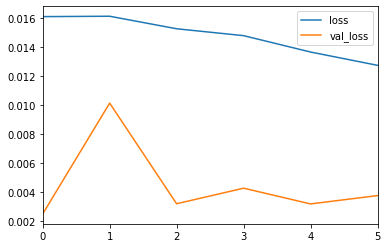

In [76]:
losses.plot()

## Processing Results

In [90]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1,length,n_features))

for i in range(len(test)):
    current_pred = model.predict(current_batch)[0]
    test_predictions.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [91]:
true_prediction = scaler.inverse_transform(test_predictions)

In [92]:
test['Predictions'] = true_prediction

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [93]:
test

,Sales,Predictions
DATE,,
2018-05-01,23764,21652.757071
2018-06-01,21589,21763.479997
2018-07-01,21919,22114.520696
2018-08-01,23381,22513.065440
2018-09-01,20260,22517.975915
2018-10-01,21473,23083.163244
2018-11-01,25831,23639.274977
2018-12-01,34706,23449.541174
2019-01-01,16410,20016.596895


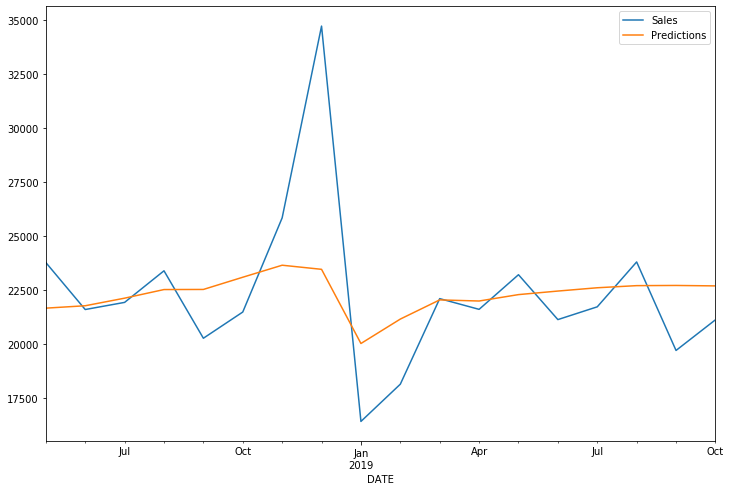

In [94]:
test.plot(figsize=(12,8))

Adding more neurons to the LSTM will give better results. 
We can also change the activation function to see if we have better results.

## Forcast to The Future

In [97]:
full_scaller = MinMaxScaler()
scaled_full_data = full_scaller.fit_transform(df)

In [100]:
length = 12
generator = TimeseriesGenerator(scaled_full_data,scaled_full_data,
                               length=length,batch_size=1)

In [122]:
model = Sequential()

model.add(LSTM(144, input_shape=(length,n_features) ))
model.add( Dense(1))
model.compile(optimizer='adam',loss='mse')

In [123]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [131]:
model.fit(generator,epochs=20)

Epoch 1/20
322/322 [==============================] - 1s 4ms/step - loss: 0.0124
Epoch 2/20
322/322 [==============================] - 1s 3ms/step - loss: 0.0165
Epoch 3/20
322/322 [==============================] - 1s 3ms/step - loss: 0.0115
Epoch 4/20
322/322 [==============================] - 1s 3ms/step - loss: 0.0113
Epoch 5/20
322/322 [==============================] - 1s 3ms/step - loss: 0.0097
Epoch 6/20
322/322 [==============================] - 1s 3ms/step - loss: 0.0095
Epoch 7/20
322/322 [==============================] - 1s 3ms/step - loss: 0.0082
Epoch 8/20
322/322 [==============================] - 1s 4ms/step - loss: 0.0074
Epoch 9/20
322/322 [==============================] - 1s 3ms/step - loss: 0.0064
Epoch 10/20
322/322 [==============================] - 1s 4ms/step - loss: 0.0053
Epoch 11/20
322/322 [==============================] - 1s 4ms/step - loss: 0.0048
Epoch 12/20
322/322 [==============================] - 1s 3ms/step - loss: 0.0040
Epoch 13/20
322/322 [====

In [146]:
forcast = []
periods = 12*3 # 3 Years

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1,length,n_features))

for i in range(periods):
    current_pred = model.predict(current_batch)[0]
    forcast.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [147]:
forcast = full_scaller.inverse_transform(forcast)

In [148]:
forcast_index = pd.date_range(start=test.index[-1],periods=periods,
                             freq='MS')

In [149]:
forcast_index

DatetimeIndex(['2019-10-01', '2019-11-01', '2019-12-01', '2020-01-01',
               '2020-02-01', '2020-03-01', '2020-04-01', '2020-05-01',
               '2020-06-01', '2020-07-01', '2020-08-01', '2020-09-01',
               '2020-10-01', '2020-11-01', '2020-12-01', '2021-01-01',
               '2021-02-01', '2021-03-01', '2021-04-01', '2021-05-01',
               '2021-06-01', '2021-07-01', '2021-08-01', '2021-09-01',
               '2021-10-01', '2021-11-01', '2021-12-01', '2022-01-01',
               '2022-02-01', '2022-03-01', '2022-04-01', '2022-05-01',
               '2022-06-01', '2022-07-01', '2022-08-01', '2022-09-01'],
              dtype='datetime64[ns]', freq='MS')

In [150]:
forcast_df = pd.DataFrame(index=forcast_index,data=forcast,columns=['Forcast'])

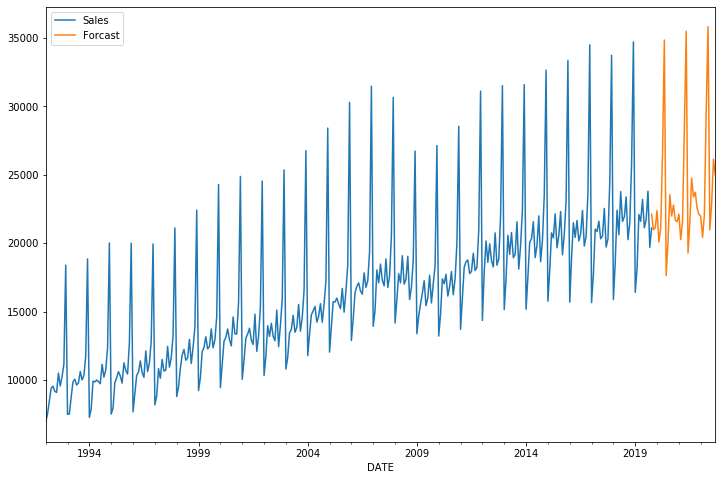

In [151]:
ax = df.plot()
forcast_df.plot(ax=ax, figsize=(12,8))

(564, 635)

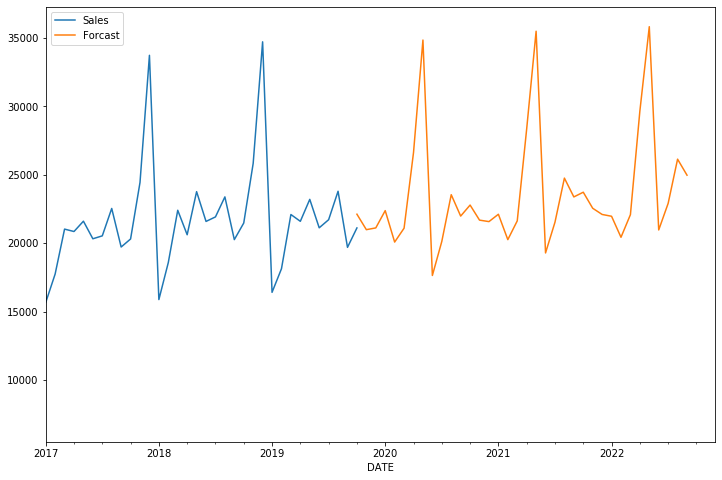

In [152]:
ax = df.plot()
forcast_df.plot(ax=ax, figsize=(12,8))
plt.xlim('2017-01-01','2022-12-01')